In [185]:
import rasterio
import numpy as np
import h3ronpy
from h3ronpy.raster import nearest_h3_resolution
from h3ronpy.pandas.raster import raster_to_dataframe
from matplotlib import pyplot as plt
import pandas as pd
import h3
import copy
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
from scipy.optimize import minimize_scalar, minimize
from shapely.geometry import Polygon, MultiPolygon, box
from shapely import wkt, unary_union
import geopandas as gpd

In [171]:
# amewoo, lobcur, buwtea, tunswa, sursco, bkpwar, sheowl, snoowl1
species = 'amewoo'

In [172]:
resolution = 3 #3,4
pathfinding_method = 'fw_vg' # fw_vg, fw, a_star, no_barriers
elevation_limit = 0

In [173]:
try:
    df = pd.read_csv(f'{species}/resolution_{resolution}/tables/h3_abundance.csv')
    df['geometry'] = df['geometry'].apply(wkt.loads)
    df = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
    m = df['value_breeding'].median()
    filtered_df = df[((df['value_breeding'] - m) > 0.01 * m)]
    breeding_favorite_threshold = filtered_df['value_breeding'].median()
except (FileNotFoundError, pd.errors.EmptyDataError):
    print("here we go again")

In [266]:
def swap_coords(coords):
    return [(lon, lat) for lat, lon in coords]

# Reading raster and creating h3 abundance map

In [5]:
resolution_factor = 0.1

# Define bounding box in EPSG:432.
bounds = (-170, -60, -30, 85)

In [8]:
os.makedirs(f"{species}/resolution_{resolution}/plots", exist_ok=True)
os.makedirs(f"{species}/resolution_{resolution}/tables", exist_ok=True)

In [9]:
# abundance files from ebird
wintering_tif_path = f"{species}/{species}_abundance_seasonal_nonbreeding_mean_2023.tif"
breeding_tif_path = f"{species}/{species}_abundance_seasonal_breeding_mean_2023.tif"

In [10]:
rasters = {
    "wintering": rasterio.open(wintering_tif_path),
    "breeding": rasterio.open(breeding_tif_path),
}

Crop to North America for now

In [11]:
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds

def reproject_downsample_and_crop(src, dst_crs="EPSG:4326", resolution_factor=1.0, 
                                 bounds=None, resampling=Resampling.nearest):
    """Reproject, downsample and crop in one operation.
    
    Args:
        src: rasterio dataset
        dst_crs: target CRS
        resolution_factor: factor to decrease resolution
        bounds: tuple of (left, bottom, right, top) to crop to
        resampling: resampling method
        
    Returns:
        tuple: (processed_array, new_transform)
    """
    # If bounds provided, first calculate transform for the area of interest
    if bounds:
        # Transform bounds to source CRS if needed
        if dst_crs != src.crs:
            from rasterio.warp import transform_bounds
            src_bounds = transform_bounds(dst_crs, src.crs, *bounds)
        else:
            src_bounds = bounds
            
        # Calculate transform for the specific bounds
        dst_transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src_bounds
        )
    else:
        # Calculate transform for entire raster
        dst_transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height,
            left=src.bounds.left, bottom=src.bounds.bottom,
            right=src.bounds.right, top=src.bounds.top
        )
    
    # Apply resolution reduction
    new_width = int(width * resolution_factor)
    new_height = int(height * resolution_factor)
    
    # Scale the transform
    scaled_transform = dst_transform * dst_transform.scale(1/resolution_factor)
    
    # Create destination array
    dst_arr = np.empty((new_height, new_width), dtype=src.meta["dtype"])
    
    # Reproject with potential window reading for efficiency
    if bounds and src_bounds:
        # Read only the window of interest for large rasters
        window = from_bounds(*src_bounds, transform=src.transform)
        src_data = src.read(1, window=window)
        src_window_transform = src.window_transform(window)
    else:
        src_data = src.read(1)
        src_window_transform = src.transform
    
    reproject(
        source=src_data,
        destination=dst_arr,
        src_transform=src_window_transform,
        src_crs=src.crs,
        dst_transform=scaled_transform,
        dst_crs=dst_crs,
        resampling=resampling
    )
    
    return dst_arr, scaled_transform



In [12]:
breeding_arr, breeding_transform = reproject_downsample_and_crop(
    rasters["breeding"],
    resolution_factor=resolution_factor,
    bounds=bounds,
    resampling=Resampling.average
)

wintering_arr, wintering_transform = reproject_downsample_and_crop(
    rasters["wintering"],
    resolution_factor=resolution_factor,
    bounds=bounds,
    resampling=Resampling.average
)

In [13]:
# raster plots after transforming and cropping

# Downsample raster to avoid huge memory usage
factor = 10  # adjust as needed
arr_small = breeding_arr[::factor, ::factor]

plt.figure(figsize=(12, 8))
plt.imshow(arr_small, cmap="viridis", origin="upper")
plt.colorbar(label="Value")
plt.title("Breeding Raster (Downsampled)")

plt.savefig(f"{species}/resolution_{resolution}/plots/breeding_raster.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [14]:
# Downsample raster to avoid huge memory usage
factor = 10  # adjust as needed
arr_small = wintering_arr[::factor, ::factor]

plt.figure(figsize=(12, 8))
plt.imshow(arr_small, cmap="viridis", origin="upper")
plt.colorbar(label="Value")
plt.title("Wintering Raster (Downsampled)")

plt.savefig(f"{species}/resolution_{resolution}/plots/wintering_raster.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [15]:
h3_res_b = nearest_h3_resolution(breeding_arr.shape, breeding_transform, search_mode="smaller_than_pixel")
h3_res_w = nearest_h3_resolution(wintering_arr.shape, wintering_transform, search_mode="smaller_than_pixel")

print(f"Using H3 resolution {h3_res_b} for breeding, {h3_res_w} for wintering")

Using H3 resolution 6 for breeding, 6 for wintering


In [16]:
# nodata_value = nan doesn't seem to work correctly
breeding_h3_df = raster_to_dataframe(
    breeding_arr,
    breeding_transform,
    h3_resolution=h3_res_b,
    # nodata_value=nodata_values['breeding'],
    compact=False,
    geo=True
)

In [17]:
wintering_h3_df = raster_to_dataframe(
    wintering_arr,
    wintering_transform,
    h3_resolution=h3_res_w,
    # nodata_value=nodata_values['wintering'],
    compact=False,
    geo=True
)

In [18]:
breeding_h3_df.head()

,value,cell,geometry
0,0.606663,603733820537044991,"POLYGON ((-70.18186 49.1703, -70.23617 49.1642..."
1,0.606663,603733821073915903,"POLYGON ((-70.10792 49.20951, -70.16229 49.203..."
2,0.606663,603733821342351359,"POLYGON ((-70.19709 49.23059, -70.25147 49.224..."
3,0.606663,603733825234665471,"POLYGON ((-70.12306 49.26982, -70.1775 49.2637..."
4,0.000059,604235945566273535,"POLYGON ((-79.3859 35.4296, -79.42501 35.42091..."


In [19]:
df_orig = breeding_h3_df.merge(
    wintering_h3_df[["cell", "value"]],
    on="cell",
    how="outer",
    suffixes=("_breeding", "_wintering")
)

In [20]:
# Drop rows where both values are zero or nans
df_orig["value_breeding"] = df_orig["value_breeding"].fillna(0)
df_orig["value_wintering"] = df_orig["value_wintering"].fillna(0)
df_orig = df_orig[(df_orig["value_breeding"] != 0) | (df_orig["value_wintering"] != 0)]

In [21]:
df_orig.head()

,value_breeding,cell,geometry,value_wintering
798223,0.006761,603733588743028735,"POLYGON ((-68.6814 50.34972, -68.73735 50.3443...",0.0
798225,0.001985,603733589011464191,"POLYGON ((-68.77208 50.37212, -68.82806 50.366...",0.0
798229,0.012987,603733589682552831,"POLYGON ((-68.5776 50.26638, -68.63344 50.2610...",0.0
798230,0.031140,603733589816770559,"POLYGON ((-68.5644 50.20554, -68.62016 50.2002...",0.0
798231,0.006761,603733589950988287,"POLYGON ((-68.66803 50.28885, -68.72389 50.283...",0.0


In [22]:
# Suppose df has fine-resolution cells
df_orig["parent"] = h3ronpy.change_resolution(df_orig["cell"], resolution).to_numpy()


In [23]:
df_orig.head()

,value_breeding,cell,geometry,value_wintering,parent
798223,0.006761,603733588743028735,"POLYGON ((-68.6814 50.34972, -68.73735 50.3443...",0.0,590222858311958527
798225,0.001985,603733589011464191,"POLYGON ((-68.77208 50.37212, -68.82806 50.366...",0.0,590222858311958527
798229,0.012987,603733589682552831,"POLYGON ((-68.5776 50.26638, -68.63344 50.2610...",0.0,590222858311958527
798230,0.031140,603733589816770559,"POLYGON ((-68.5644 50.20554, -68.62016 50.2002...",0.0,590222858311958527
798231,0.006761,603733589950988287,"POLYGON ((-68.66803 50.28885, -68.72389 50.283...",0.0,590222858311958527


In [24]:
df_inter = df_orig.groupby("parent", as_index=False).agg({
    "value_wintering": "sum",
    "value_breeding": "sum"
})


In [25]:
df_inter['cell'] = df_inter['parent'].apply(lambda x: '{:x}'.format(x))

In [26]:
df_inter.head()

,parent,value_wintering,value_breeding,cell
0,590222858311958527,0.0,17.140312,830e48fffffffff
1,590222927031435263,0.0,123.973282,830e49fffffffff
2,590222995750911999,0.0,0.273110,830e4afffffffff
3,590223064470388735,0.0,139.002182,830e4bfffffffff
4,590223201909342207,0.0,61.548981,830e4dfffffffff


In [28]:
df_inter["geometry"] = df_inter["cell"].apply(lambda c: Polygon(swap_coords(h3.cell_to_boundary(c))))

In [29]:
df_inter.head()

,parent,value_wintering,value_breeding,cell,geometry
0,590222858311958527,0.0,17.140312,830e48fffffffff,POLYGON ((-68.66051795296585 51.03692762347239...
1,590222927031435263,0.0,123.973282,830e49fffffffff,POLYGON ((-67.84615854534232 50.02359076660325...
2,590222995750911999,0.0,0.273110,830e4afffffffff,"POLYGON ((-70.5047130881611 51.06900759477657,..."
3,590223064470388735,0.0,139.002182,830e4bfffffffff,"POLYGON ((-69.64257912259468 50.0670433948732,..."
4,590223201909342207,0.0,61.548981,830e4dfffffffff,POLYGON ((-66.82605853886493 50.97612378631565...


In [30]:
df = gpd.GeoDataFrame(df_inter.drop(columns=["parent"]), geometry="geometry", crs="EPSG:4326")

In [31]:
# Normalization
total_breeding = df["value_breeding"].sum()
total_wintering = df["value_wintering"].sum()

df["value_breeding"] = df["value_breeding"] / total_breeding
df["value_wintering"] = df["value_wintering"] / total_wintering


# можно ли нормализовать так, чтобы для территорий, в которых  есть наблюдения в оба сезона, вес был один и тот же? надо ли

In [32]:
m = df['value_breeding'].median()
filtered_df = df[((df['value_breeding'] - m) > 0.01 * m)]
breeding_favorite_threshold = filtered_df['value_breeding'].median()

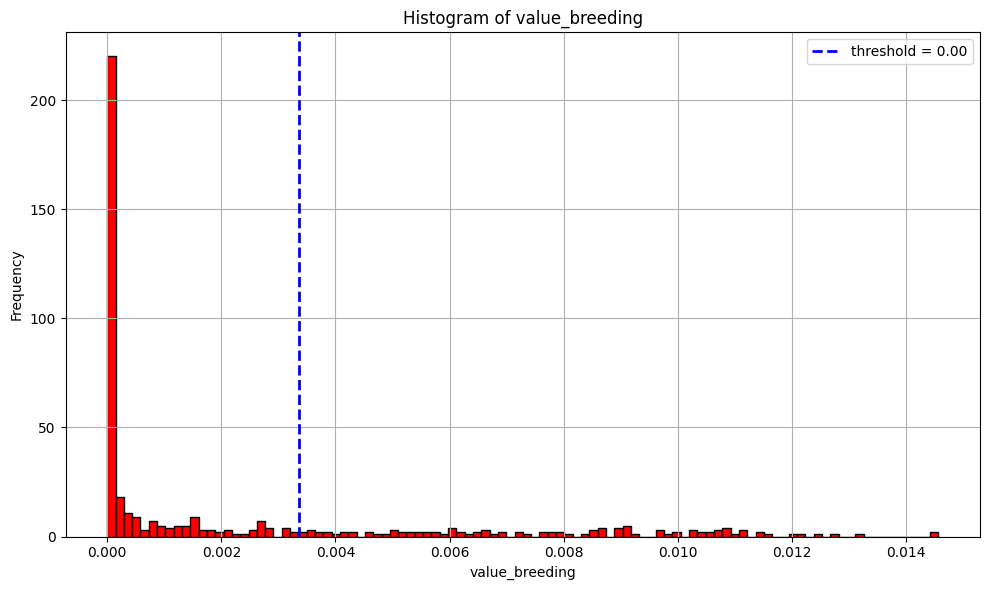

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df["value_breeding"], bins=100, color='red', edgecolor='black')
ax.axvline(breeding_favorite_threshold, color='blue', linestyle='--', linewidth=2, label=f'threshold = {breeding_favorite_threshold:.2f}')

ax.legend()
#ax.set_ylim(0, 200) 
ax.set_title("Histogram of value_breeding")
ax.set_xlabel("value_breeding")
ax.set_ylabel("Frequency")
ax.grid(True)
fig.tight_layout()
fig.savefig(f"{species}/resolution_{resolution}/plots/value_breeding_hist.pdf", dpi=300, bbox_inches="tight")
plt.show()

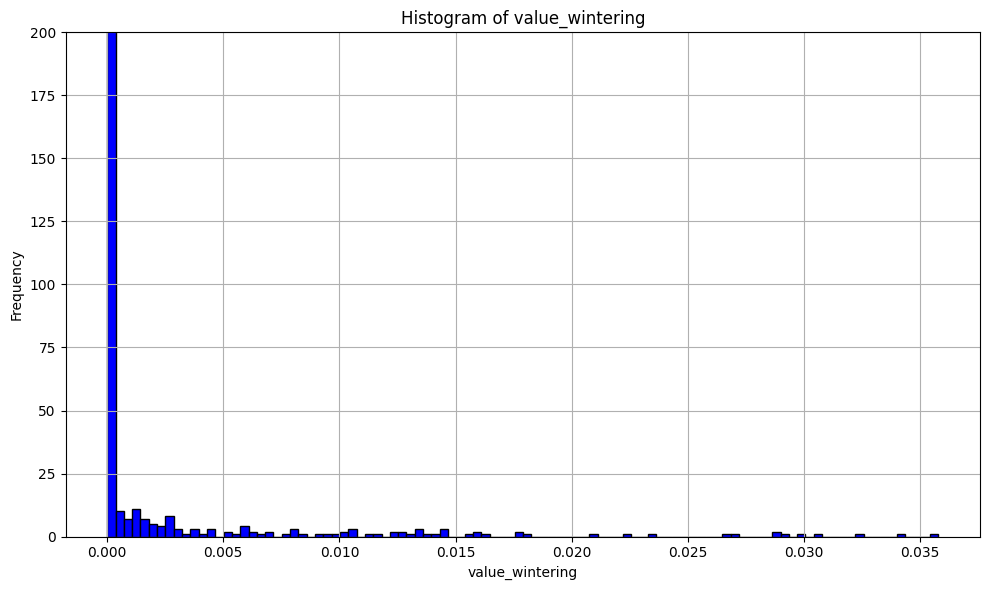

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df["value_wintering"], bins=100, color='blue', edgecolor='black')
ax.set_ylim(0, 200)  # This avoids using plt.ylim
ax.set_title("Histogram of value_wintering")
ax.set_xlabel("value_wintering")
ax.set_ylabel("Frequency")
ax.grid(True)
fig.tight_layout()
fig.savefig(f"{species}/resolution_{resolution}/plots/value_wintering_hist.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [35]:
# plot breeding abundance map
df.plot(column="value_breeding", linewidth=0.2, edgecolor=None, figsize=(30, 10), legend=True)
plt.savefig(f"{species}/resolution_{resolution}/plots/h3_b.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [36]:
# plot wintering abundance map
df.plot(column="value_wintering", linewidth=0.2, edgecolor=None, figsize=(30, 10), legend=True)
plt.savefig(f"{species}/resolution_{resolution}/plots/h3_w.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [37]:
# plot difference map
df["diff"] = df["value_breeding"] / df["value_breeding"].max()  - df["value_wintering"] / df["value_wintering"].max()

# Determine the symmetric range around zero
max_abs = np.nanmax(np.abs(df["diff"]))
vmin, vmax = -1, 1

ax = df.plot(
    column="diff",
    linewidth=0,
    edgecolor=None,
    legend=True,
    cmap="coolwarm",  # diverging for positive/negative differences
    figsize=(30, 10),
    vmin=vmin,
    vmax=vmax  # ensures zero is in the center
)
plt.title("Breeding - Wintering")
plt.savefig(f"{species}/resolution_{resolution}/plots/h3_diff_norm.pdf", dpi=300, bbox_inches="tight")
plt.close()


In [38]:
# coordinates
latlng_map = df['cell'].apply(lambda c: pd.Series(h3.cell_to_latlng(c), index=['lat', 'lng']))
df = pd.concat([df, latlng_map], axis=1)

In [39]:
df = df.loc[:, ~df.columns.duplicated()]
df.head()

,value_wintering,value_breeding,cell,geometry,diff,lat,lng
0,0.0,0.001331,830e48fffffffff,"POLYGON ((-68.66052 51.03693, -69.60227 50.726...",0.091357,50.377492,-68.716097
1,0.0,0.009625,830e49fffffffff,"POLYGON ((-67.84616 50.02359, -68.76993 49.720...",0.660773,49.369298,-67.913007
2,0.0,0.000021,830e4afffffffff,"POLYGON ((-70.50471 51.06901, -71.43508 50.743...",0.001456,50.407920,-70.530963
3,0.0,0.010792,830e4bfffffffff,"POLYGON ((-69.64258 50.06704, -70.55639 49.749...",0.740877,49.410776,-69.681628
4,0.0,0.004779,830e4dfffffffff,"POLYGON ((-66.82606 50.97612, -67.77717 50.680...",0.328054,50.319110,-66.910550


In [40]:
df.to_csv(f'{species}/resolution_{resolution}/tables/h3_abundance.csv', index = False)

# Pathfinding (change path)

## Obstacles generation from maps

### Polygon

In [210]:
from h3 import LatLngPoly

In [211]:
# Optional: swap (lat, lng) to (lng, lat) if needed
def swap_coords(coords):
    return [(lon, lat) for lat, lon in coords]

def clean_coords(coords, ndigits=6):
    return [(round(x, ndigits), round(y, ndigits)) for x, y in coords]

# Convert H3 cells to polygons
def h3_cells_to_gdf(cells):
    polygons = [Polygon(swap_coords(h3.cell_to_boundary(c))) for c in cells]
    return gpd.GeoDataFrame({'cell': cells}, geometry=polygons, crs="EPSG:4326")

In [281]:
boundaries = [
    [
        (40, -81),
        (43, -85),
        (40, -80),
        (39, -80),
        (39, -90),
        (40, -90)
    ],
    [
        (41, -87),
        (43, -89),
        (43, -90)
    ]
]


# Create the polygon shape
barriers_latlng = MultiPolygon([Polygon(clean_coords(swap_coords(b))) for b in boundaries])
barriers = MultiPolygon([
    Polygon(clean_coords(transform(transformer.transform, Polygon(swap_coords(b))).exterior.coords))
    for b in boundaries
])

### Elevation map

In [6]:
dem_directory = 'gt30'

In [7]:
tiles = []
for filename in os.listdir(dem_directory):
    filepath = os.path.join(dem_directory, filename)
    raster_tile = rasterio.open(filepath)
    tiles.append(raster_tile)

In [8]:
from rasterio.merge import merge

In [9]:
elevation, elevation_transform = merge(tiles)

In [10]:
tiles[0].profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4800, 'height': 6000, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.00833333333333, 0.0, 20.000000000000004,
       0.0, -0.00833333333333, 90.0), 'blockxsize': 4800, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

In [11]:
nodata = tiles[0].profile['nodata']

In [12]:
mask = np.where((elevation == nodata) | (elevation > elevation_limit), 1, 0)

In [13]:
factor = 10  # adjust as needed
elevation_small = elevation.squeeze()[::factor, ::factor]

plt.figure(figsize=(12, 8))
plt.imshow(elevation_small, cmap="viridis", origin="upper")
plt.colorbar(label="Value")
plt.title("Elevation (Downsampled)")

plt.savefig(f"{species}/plots/elevation_raster.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [112]:
factor = 10  # adjust as needed
elevation_small = mask.squeeze()[::factor, ::factor]

plt.figure(figsize=(12, 8))
plt.imshow(elevation_small, cmap="viridis", origin="upper")
plt.colorbar(label="Value")
plt.title("Border Raster (Downsampled)")

plt.savefig(f"{species}/plots/elevation_border_raster.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [14]:
elevation_res = nearest_h3_resolution(elevation[0].shape, elevation_transform, search_mode="smaller_than_pixel")
elevation_res

9

In [15]:
resolution_factor = 0.1
height, width = mask[0].shape
new_shape = (int(height * resolution_factor), int(width * resolution_factor))
downscaled = np.empty(new_shape, dtype=mask.dtype)

barriers_raster = reproject(
    source=mask,
    destination=downscaled,
    src_transform=elevation_transform,
    src_crs="EPSG:4326",
    dst_transform=elevation_transform * elevation_transform.scale(1/resolution_factor),
    dst_crs="EPSG:4326",
    resampling=Resampling.nearest
)

In [16]:
elevation_res = nearest_h3_resolution(barriers_raster[0].shape, barriers_raster[1], search_mode="smaller_than_pixel")
elevation_res

6

In [17]:
elevation_df = raster_to_dataframe(
    barriers_raster[0],
    barriers_raster[1],
    h3_resolution=elevation_res,
    compact=False,
    geo=True
)

In [18]:
elevation_df["value"] = elevation_df["value"].fillna(0)

In [19]:
elevation_df["parent"] = h3ronpy.change_resolution(elevation_df["cell"], resolution).to_numpy()

In [20]:
len(elevation_df)

13179155

In [21]:
len(elevation_df) - elevation_df['value'].sum()

np.int64(3455925)

In [22]:
elevation_df.head()

,value,cell,geometry,parent
0,1,603482350201864191,"POLYGON ((37.98599 79.21043, 38.15556 79.21843...",594475159402840063
1,1,603482350336081919,"POLYGON ((37.89067 79.26631, 38.06106 79.27437...",594475159402840063
2,1,603482350470299647,"POLYGON ((38.28714 79.19441, 38.45677 79.20224...",594475159402840063
3,1,603482350604517375,"POLYGON ((38.19355 79.25038, 38.364 79.25828, ...",594475159402840063
4,1,603482350738735103,"POLYGON ((37.7801 79.17037, 37.94881 79.17847,...",594475159402840063


In [23]:
elevation_df = elevation_df.groupby("parent", as_index=False).agg({
    "value": "min"
})

In [24]:
elevation_df = elevation_df[(elevation_df["value"] != 0)]

In [25]:
elevation_df['cell'] = elevation_df['parent'].apply(lambda x: '{:x}'.format(x))

In [26]:
def swap_coords(coords):
    return [(lon, lat) for lat, lon in coords]

In [27]:
elevation_df["geometry"] = elevation_df["cell"].apply(lambda c: Polygon(swap_coords(h3.cell_to_boundary(c))))
elevation_df.head()

,parent,value,cell,geometry
0,594475159402840063,1,8400001ffffffff,POLYGON ((37.766293232309394 79.01879305290238...
1,594475167992774655,1,8400003ffffffff,"POLYGON ((37.08186066491649 79.4085712163791, ..."
2,594475176582709247,1,8400005ffffffff,"POLYGON ((39.821706055974985 78.9019302644216,..."
3,594475185172643839,1,8400007ffffffff,"POLYGON ((39.22084486674897 79.29640634342562,..."
4,594475193762578431,1,8400009ffffffff,"POLYGON ((36.39046663786997 78.73611355290785,..."


In [28]:
elevation_df = gpd.GeoDataFrame(elevation_df.drop(columns=["parent"]), geometry="geometry", crs="EPSG:4326")

In [29]:
def no_crossing_antimeridian(geom):
    minx, miny, maxx, maxy = geom.bounds
    return (maxx - minx) <= 180

In [30]:
elevation_no_cross = elevation_df[elevation_df.geometry.apply(no_crossing_antimeridian)]

In [31]:
# plot breeding abundance map
elevation_no_cross.plot(column="value", linewidth=0.2, edgecolor=None, figsize=(30, 10), legend=True)
plt.savefig(f"{species}/plots/elevation_barriers.pdf", dpi=300, bbox_inches="tight")
plt.close()

### Shorelines

In [1]:
import regionmask

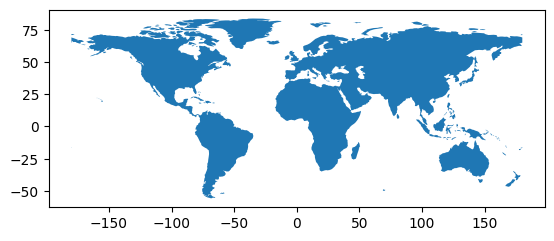

In [10]:
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
gdf_land = gpd.GeoSeries(land.polygons, crs="EPSG:4326")

# remove antarctic
geom = gdf_land.geometry.iloc[0]
polygons = list(geom.geoms)
polygons_no_antarctica = [
    p for p in polygons
    if p.bounds[3] > -60
]
gdf_land.geometry.iloc[0] = MultiPolygon(polygons_no_antarctica)
gdf_land.plot()
plt.show()

In [11]:
from pyproj import CRS

aeqd_na = CRS.from_proj4(
    "+proj=aeqd "
    "+lat_0=90 "
    "+lon_0=0 "
    "+x_0=0 "
    "+y_0=0 "
    "+datum=WGS84 "
    "+units=m "
    "+no_defs"
)

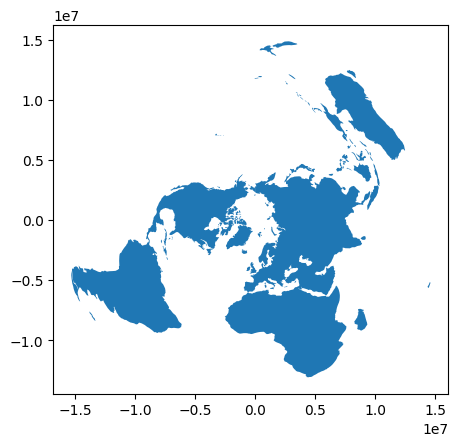

In [12]:
gdf_land_aeqd = gdf_land.to_crs(aeqd_na)
gdf_land_aeqd.plot()
plt.show()

In [14]:
margin_distance = 300000
buffered = gdf_land_aeqd.buffer(margin_distance)
rough_polygon = buffered.simplify(tolerance=200000, preserve_topology=True)
final_polygon = rough_polygon.buffer(0)

In [20]:
world = box(-1.6e7, -1.6e7, 1.6e7, 1.6e7)

#check this
def safe_union(geoms):
    fixed = geoms.apply(lambda g: shapely.make_valid(g) if not g.is_valid else g)
    fixed = fixed[~fixed.is_empty & fixed.notnull()]
    return unary_union(fixed.values)

land_shape = safe_union(final_polygon.geometry)
ocean_polygon = world.difference(land_shape)
gdf_ocean = gpd.GeoDataFrame(geometry=[ocean_polygon])

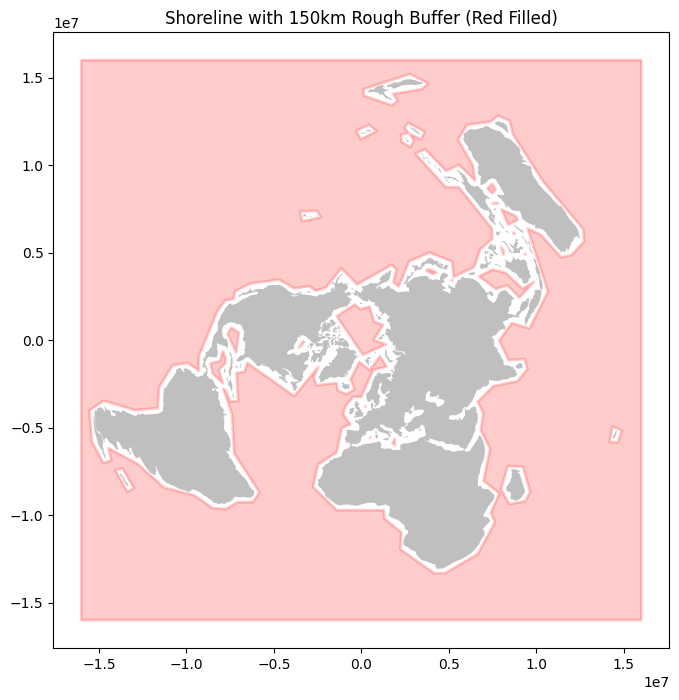

In [22]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
gdf_ocean.plot(ax=ax,
                   edgecolor='red',
                   facecolor='red',
                   alpha=0.2,
                   linewidth=2,
                   label='Rough Margin')
gdf_land_aeqd.plot(ax=ax, color='gray', alpha=0.5, label='Original Land')

ax.set_title("Shoreline with 150km Rough Buffer (Red Filled)")
plt.show()

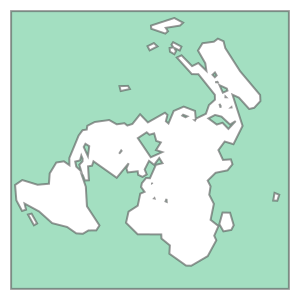

In [46]:
barrier_ocean = gdf_ocean.geometry[0]
barrier_ocean

## Barrier intersection

barriers is a list of polygons here. decide whether to use polygons themselves or store polygons instead of ids or change the function to accept ids or both

In [177]:
from shapely.geometry import Polygon, LineString
from pyproj import Geod
from shapely.prepared import prep

In [3]:
geod = Geod(ellps="WGS84")

def clean_coords(coords, ndigits=12):
    return [(round(lon, ndigits), round(lat, ndigits)) for lon, lat in coords]

def great_circle_intersects_polygon(pt1, pt2, barriers, num_points=10):
    lat1, lon1 = pt1
    lat2, lon2 = pt2

    # Get geodesic points
    pts = geod.npts(lon1, lat1, lon2, lat2, num_points,
                    initial_idx=0, terminus_idx=0)

    coords = clean_coords([(p[0], p[1]) for p in pts])
    line = LineString(coords)

    for poly in barriers:
        if line.crosses(poly) or poly.contains(line):
            return True

    return False

In [19]:
# Example
ptA = (60, -170)
ptB = (60, 170)



barriers = [
    #Polygon([(39.0, -110.0), (41.0, -100.0), (35.0, -100.0)]),
    Polygon([(0, 65), (1, 65), (0, 55)])
]

print(great_circle_intersects_polygon(ptA, ptB, barriers))

True


In [20]:
compute_geodesic_line(ptA, ptB)

[(-170.0, 60.000000000000014),
 (-174.97111332928228, 60.28377877496189),
 (-180.0, 60.37897664463513),
 (174.97111332928228, 60.28377877496189),
 (170.0, 60.000000000000014)]

Read this later. this is for previous version which accepts border.

[(-170.0, 60.0), (-174.971113329282, 60.283778774962), (-180.0, 60.378976644635), (174.971113329282, 60.283778774962), (170.0, 60.0)]


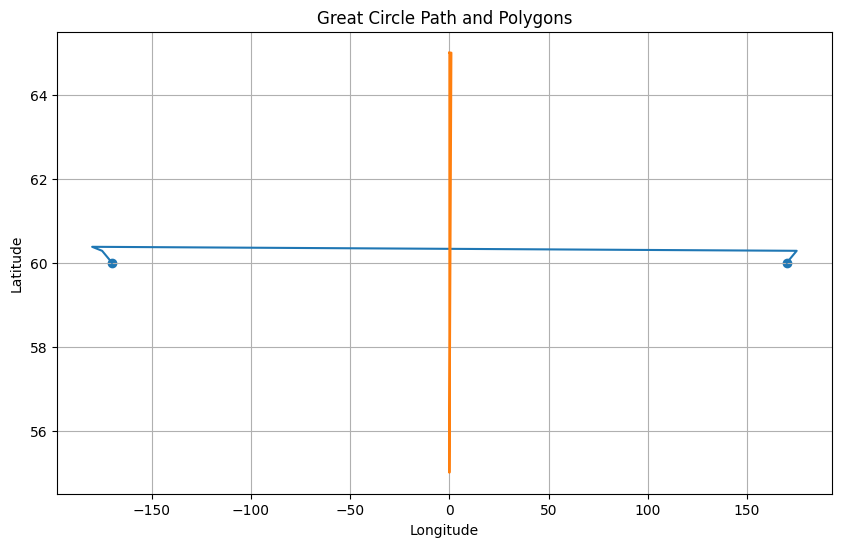

In [21]:
def normalize_npts_output(pts):
    if isinstance(pts, tuple) and len(pts) == 2:
        lons, lats = pts
        return list(zip(lons, lats))
    elif isinstance(pts, list):
        if len(pts) == 0:
            return []
        sample = pts[0]
        if isinstance(sample, dict):
            return [(p["lon"], p["lat"]) for p in pts]
        elif isinstance(sample, (list, tuple)) and len(sample) == 2:
            return [(p[0], p[1]) for p in pts]
    raise TypeError("Unsupported npts output format")


# Compute great circle line
def compute_geodesic_line(pt1, pt2, num_points=5):
    lat1, lon1 = pt1
    lat2, lon2 = pt2
    pts = geod.npts(
        lon1, lat1,
        lon2, lat2,
        num_points,
        initial_idx=0, 
        terminus_idx=0
    )
    return pts

line_coords = clean_coords(compute_geodesic_line(ptA, ptB))
print(line_coords)

# Plot
plt.figure(figsize=(10, 6))

# Plot line
lons, lats = zip(*line_coords)
plt.plot(lons, lats, label="Great Circle Path")

# Plot polygons
for poly in barriers:
    x, y = poly.exterior.xy
    plt.plot(x, y)


# Mark endpoints
plt.scatter([ptA[1], ptB[1]], [ptA[0], ptB[0]])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Great Circle Path and Polygons")
plt.grid(True)
plt.show()

## Barrier intersection azimuthal equidistant projection

In [178]:
from shapely.geometry import LineString
from pyproj import CRS, Geod, Transformer
from shapely.ops import transform
from shapely.prepared import prep

In [239]:
geod = Geod(ellps="WGS84")

def clean_coords(coords, ndigits=6):
    return [(round(x, ndigits), round(y, ndigits)) for x, y in coords]

def great_circle_intersects_multipolygon(pt1, pt2, barrier, transformer, num_points=10, plot=False):
    """
    pt1, p2 in lat lon
    barrier in aeqd/other projection
    transformer - pyproj.Transformer from lat lon to aeqd/other projection
    num_points - number of point to approximate great circle arc with
    plot - whether to draw a plot with the barrier and great circle arc
    """
    
    lat1, lon1 = pt1
    lat2, lon2 = pt2

    # Get geodesic points
    pts = geod.npts(lon1, lat1, lon2, lat2, num_points,
                    initial_idx=0, terminus_idx=0)

    xs, ys = transformer.transform([p[0] for p in pts], [p[1] for p in pts])
    coords = clean_coords(zip(xs, ys))
    
    line = LineString(coords)

    if plot:
        fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
        
        for poly in barrier.geoms:  
            x, y = poly.exterior.xy
            ax.fill(x, y, 
                    edgecolor='none',
                    facecolor='red',
                    alpha=0.2,
                    label='barrier')
            # plot interior holes
            for interior in poly.interiors:
                ix, iy = interior.xy
                ax.fill(
                    ix, iy,
                    edgecolor='none',
                    facecolor='white',   # background color → hole
                    alpha=1
                )


        plt.plot(xs, ys, label="Great Circle Path")

        # global variable???
        gdf_land_aeqd.plot(ax=ax, color='gray', alpha=0.5, label='Original Land')


        plt.show()

    # Check intersection
    if line.crosses(barrier) or barrier.contains(line):
        return True

    return False

In [262]:
transformer = Transformer.from_crs("EPSG:4326", aeqd_na, always_xy=True)
reverse_transformer = Transformer.from_crs(aeqd_na, "EPSG:4326", always_xy=True)

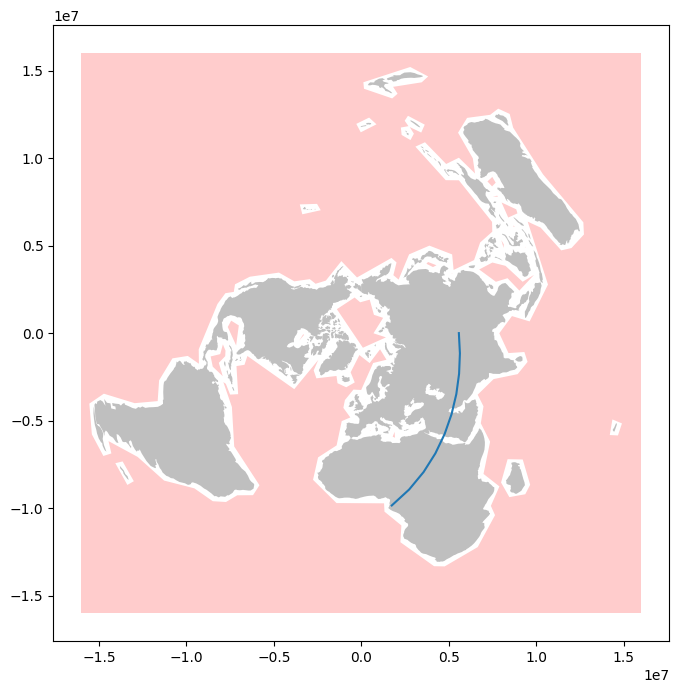

False

In [241]:
pt1 = (40, 90)
pt2 = (0, 10)

great_circle_intersects_multipolygon(pt1, pt2, barrier_ocean, transformer, plot=True)

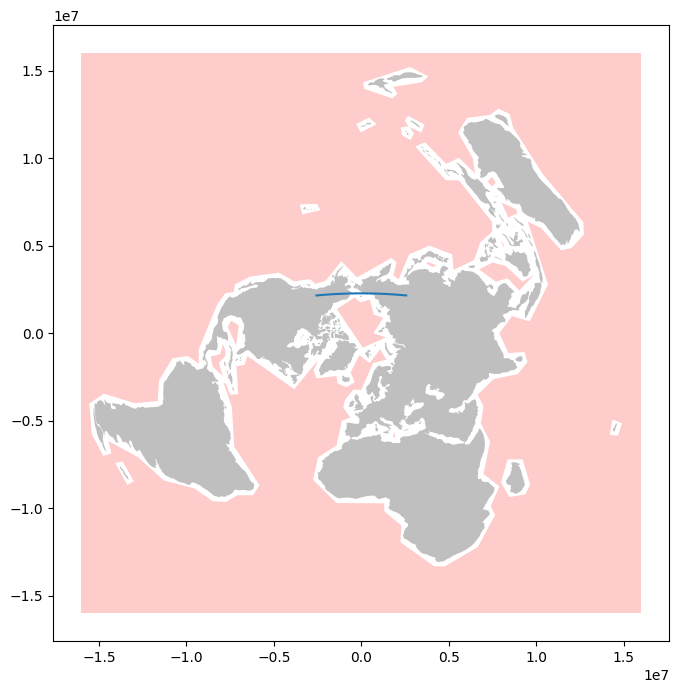

False

In [242]:
pt1 = (60, 130)
pt2 = (60, -130)

great_circle_intersects_multipolygon(pt1, pt2, barrier_ocean, transformer, plot=True)

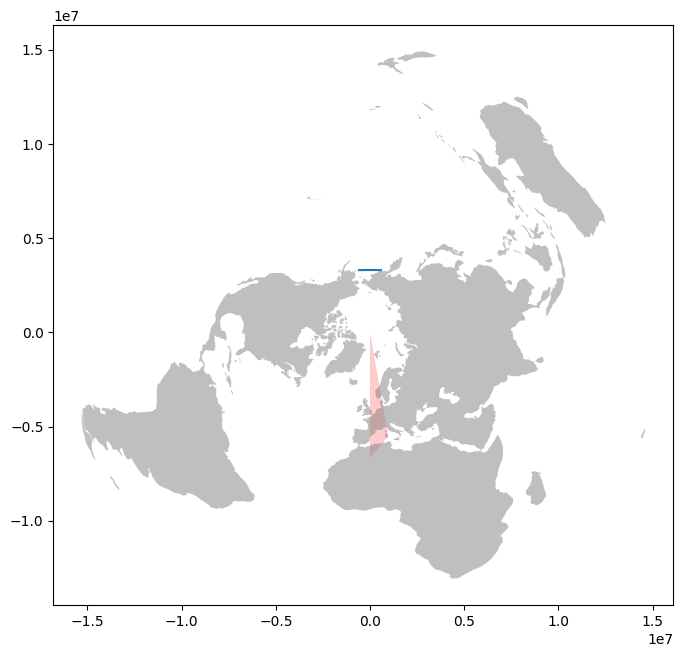

False

In [243]:
ptA = (60, -170)
ptB = (60, 170)


barriers_latlon = [
    Polygon([(0, 90), (10, 40), (0, 30)])
]

barriers_aeqd = MultiPolygon([transform(transformer.transform, polygon) for polygon in barriers_latlon])


great_circle_intersects_multipolygon(ptA, ptB, barriers_aeqd, transformer, plot=True)

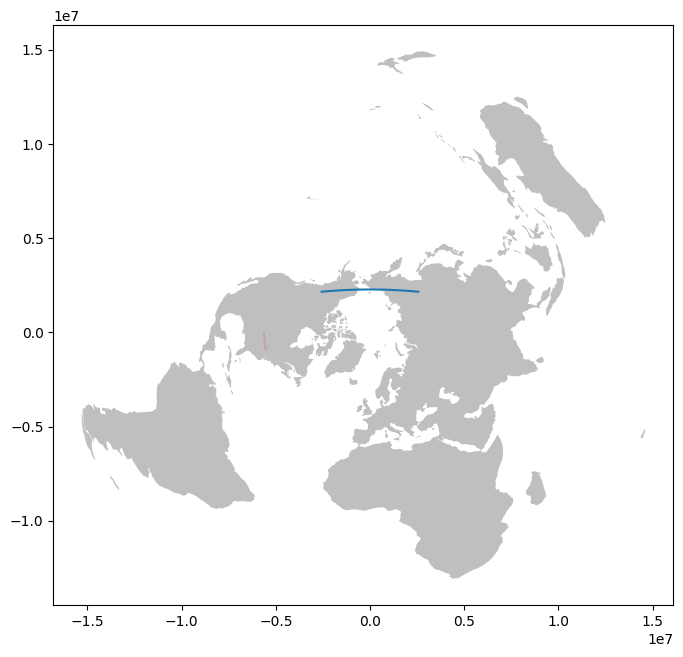

False

In [248]:
pt1 = (60, 130)
pt2 = (60, -130)

great_circle_intersects_multipolygon(pt1, pt2, barriers, transformer, plot=True)

## Shortest path

### A*

In [13]:
import heapq

In [10]:
from shapely.geometry import Point

In [22]:
def a_star(origin, target, barriers):
    if not target or target in barriers:
        return []

    def inBarrier(cell, barriers):
        lat, lng = h3.cell_to_latlng(cell)
        pt = Point(lng, lat)
        for poly in barriers:
            if poly.contains(pt):
                return True
        return False
        
    # Priority queue: (priority, h3Index)
    frontier = [(0, origin)]
    came_from = {origin: None}
    cost_so_far = {origin: 0}

    while frontier:
        _, current = heapq.heappop(frontier)
        if current == target:
            break

        # Get neighbors excluding barriers
        neighbors = [h for h in h3.grid_ring(current, 1) if h != current and h != None and not inBarrier(h, barriers)]

        for neighbor in neighbors:
            new_cost = cost_so_far[current] + 1
            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                priority = new_cost + h3.great_circle_distance(h3.cell_to_latlng(neighbor), h3.cell_to_latlng(target), unit='km')
                heapq.heappush(frontier, (priority, neighbor))
                came_from[neighbor] = current

    # Reconstruct path
    if target not in came_from:
        return []

    path = []
    current = target
    while current != origin:
        path.append(current)
        current = came_from[current]
    path.reverse()

    return path

In [114]:
def relax_path(cell_path, barriers):
    n = len(cell_path)
    if n == 0:
        return float('inf'), cell_path
        
    relaxed = [cell_path[0]]
    length = 0

    i = 0
    while i < n - 1:
        j = i + 1
        last_good = j
        cell_i = cell_path[i]

        while j < n:
            cell_j = cell_path[j]
            if not great_circle_intersects_polygon(h3.cell_to_latlng(cell_i), h3.cell_to_latlng(cell_j), barriers, 5):
                last_good = j
                j += 1
            else:
                break

        relaxed.append(cell_path[last_good])
        length += h3.great_circle_distance(h3.cell_to_latlng(cell_i), h3.cell_to_latlng(cell_path[last_good]), unit='km')
        i = last_good

    return length, relaxed


In [104]:
#barriers = set(elevation_no_cross['cell'].astype(str))

In [62]:
print(all_routes_path_length.iloc[150])

departure_cell                                         840e487ffffffff
departure_value                                                    0.0
destination_cell                                       8444e53ffffffff
destination_value                                                  0.0
length_km                                                  2593.449662
intersection                                                      True
path                 [840e487ffffffff, 842a855ffffffff, 8444c5bffff...
Name: 7808, dtype: object


In [105]:
origin = '840e487ffffffff'# '840e481ffffffff'
target = '8444e53ffffffff'# '8426419ffffffff'

In [106]:
path = a_star(origin, target, barriers)

In [107]:
len(path)

72

In [110]:
length, relaxed_path = relax_path(path, barriers)
len(relaxed_path)

4

In [66]:
print(origin, target)
print(list(barriers)[:5])

840e487ffffffff 8444e53ffffffff
[<POLYGON ((-90 40, -80 40, -80 39, -90 39, -90 40))>]


In [89]:
# Create GeoDataFrame for barriers
path_gdf = h3_cells_to_gdf(path)
relaxed_path_gdf = h3_cells_to_gdf(relaxed_path)


# Plot base layer
ax = df.plot(
    facecolor="wheat",
    linewidth=0.2,
    edgecolor="tan",
    figsize=(30, 10),
    legend=True
)



# Overlay barriers in red
path_gdf.plot(ax=ax, facecolor="blue", edgecolor="blue", alpha=0.5, linewidth=0.5)
relaxed_path_gdf.plot(ax=ax, facecolor="red", edgecolor="red", alpha=0.5, linewidth=0.5)

for poly in barriers:
    x, y = poly.exterior.xy
    plt.plot(x, y)

#ax.set_xlim((60, 150))

# Save the combined plot
plt.savefig(f"{species}/resolution_{resolution}/plots/path_a_star.pdf", dpi=300, bbox_inches="tight")
plt.close()

### Primed Floyd-Warshall on cells

think on the fact that our graph is undirected
can we do this in half the time?

In [11]:
def primed_floyd_warshall(df, all_routes):
    cells = list(df['cell'])

    # Separate direct edges and queries
    edges = []
    queries = []

    for row in all_routes.itertuples(index=False):
        u = row.departure_cell
        v = row.destination_cell
        d = row.length_km
        p = row.path   # may be a list or None

        if row.intersection == False:
            # direct edge (shortest)
            edges.append((u, v, d, p))
        else:
            queries.append((u, v))

    # Initialize dist and path maps
    dist = {}
    path = {}

    for i in cells:
        for j in cells:
            dist[(i, j)] = float('inf')
            path[(i, j)] = None

    # Load real edges (guaranteed shortest)
    for (u, v, d, p) in edges:
        dist[(u, v)] = d
        path[(u, v)] = p[:]  # shallow copy just in case

    # Self distances
    for i in cells:
        dist[(i, i)] = 0
        path[(i, i)] = [i]

    # Initialize placeholder paths for queries with no direct edge
    for (u, v) in queries:
        if path[(u, v)] is None:
            path[(u, v)] = [u, v]

    # Main relaxation
    for k in cells:
        for (u, v) in queries: # i think this is wrong. just remove it later.
            dik = dist[(u, k)]
            if dik == float('inf'):
                continue

            new_dist = dik + dist[(k, v)]
            if new_dist < dist[(u, v)]:
                dist[(u, v)] = new_dist
                path[(u, v)] = path[(u, k)] + path[(k, v)][1:]

    # Write results back
    out = all_routes.copy()

    for idx, row in out.iterrows():
        if row['intersection'] == True:
            u = row['departure_cell']
            v = row['destination_cell']
            out.at[idx, 'length_km'] = dist[(u, v)]
            out.at[idx, 'path'] = path[(u, v)]

    return out

### fw on a visibility graph

In [273]:
def floyd_warshall_visibility_graph(all_routes, barriers, barriers_latlng):
    departures = set()
    destinations = set()
    nodes = set()
    dist = {}
    path = {}

    # do i need this? rewrite.
    def rnd(coords, n):
        x, y = coords
        return (round(x, n), round(y, n))
    dig = 6

    queries_df = all_routes[all_routes['intersection'] == True]
    for row in queries_df.itertuples(index=False):
        u = row.departure_cell
        v = row.destination_cell
        u_coords = rnd(h3.cell_to_latlng(u), dig)
        v_coords = rnd(h3.cell_to_latlng(v), dig)
        departures.add(u_coords)
        destinations.add(v_coords)
        dist[(u_coords, v_coords)] = dist[(v_coords, u_coords)] = float('inf')
        path[( u_coords, v_coords )] = None

    # visibility graph
    
    # edges between dep, dest and polygon nodes
    for u_coords in departures:
        for poly in barriers_latlng.geoms:
            for p_lng, p_lat in poly.exterior.coords[:-1]:
                # u -> p
                # if not great_circle_intersects_polygon(u_coords, (p_lat, p_lng), barriers, num_points=5):
                if not great_circle_intersects_multipolygon(u_coords, (p_lat, p_lng), barriers, transformer, num_points=5):
                    dist[( u_coords, (p_lat, p_lng) )] = h3.great_circle_distance(
                            u_coords,
                            (p_lat, p_lng), 
                            unit='km'
                        )
                    path[( u_coords, (p_lat, p_lng) )] = [u_coords, (p_lat, p_lng)]
                else:
                    dist[( u_coords, (p_lat, p_lng) )] = float('inf')
    
    for v_coords in destinations:
        for poly in barriers_latlng.geoms:
            for p_lng, p_lat in poly.exterior.coords[:-1]:
                # p -> v    
                # if not great_circle_intersects_polygon(v_coords, (p_lat, p_lng), barriers, num_points=5):
                if not great_circle_intersects_multipolygon(v_coords, (p_lat, p_lng), barriers, transformer, num_points=5):
                    dist[( (p_lat, p_lng), v_coords )] = h3.great_circle_distance(
                            v_coords,
                            (p_lat, p_lng), 
                            unit='km'
                        )
                    path[( (p_lat, p_lng), v_coords )] = [(p_lat, p_lng), v_coords]
                else:
                    dist[( (p_lat, p_lng), v_coords )] = float('inf')

    # edges between polygon nodes
    n_barriers = len(barriers.geoms)
    for i in range(n_barriers): 
        poly = barriers_latlng.geoms[i]
        coords = swap_coords(poly.exterior.coords)
        n_nodes_i = len(coords) - 1

        nodes.update(coords[:-1])

        # connect adjacent nodes an error
        for p in range(n_nodes_i):
            a = coords[p]
            b = coords[p+1]    
            
            d = h3.great_circle_distance(a, b, unit='km')
            dist[(a, a)] = 0
            dist[(a, b)] = dist[(b, a)] = d
            path[(a, b)] = [a, b]
            path[(b, a)] = [b, a]

            # connect with other nodes in poly
            for q in range(p+2, n_nodes_i):
                if q-p >= n_nodes_i - 1:
                    continue
                a = coords[p]
                b = coords[q]
                # if not great_circle_intersects_polygon(a, b, barriers, num_points=5):
                if not great_circle_intersects_multipolygon(a, b, barriers, transformer, num_points=5):
                    d = h3.great_circle_distance(a, b, unit='km')
                    dist[(a, b)] = dist[(b, a)] = d
                    path[(a, b)] = [a, b]
                    path[(b, a)] = [b, a]
                else:
                    dist[(a, b)] = dist[(b, a)] = float('inf')

        # connect with other barriers
        for j in range(i+1, n_barriers):
            poly_j = barriers_latlng.geoms[j]
            coords_j = swap_coords(poly_j.exterior.coords[:-1])

            for p_i in coords:
                for p_j in coords_j:
                    # if not great_circle_intersects_polygon(p_i, p_j, barriers, num_points=5):
                    if not great_circle_intersects_multipolygon(p_i, p_j, barriers, transformer, num_points=5):
                        d = h3.great_circle_distance(p_i, p_j, unit='km')
                        dist[(p_i, p_j)] = dist[(p_j, p_i)] = d
                        path[(p_i, p_j)] = [p_i, p_j]
                        path[(p_j, p_i)] = [p_j, p_i]
                    else:
                        dist[(p_i, p_j)] = dist[(p_j, p_i)] = float('inf')

    departures |= nodes
    destinations |= nodes
    
    # Main relaxation 
    for k in nodes:
        for i in departures:
            for j in destinations:                
                dik = dist[(i, k)]
                dkj = dist[(k, j)]
                if dik == float('inf') or dkj == float('inf'):
                    continue
    
                new_dist = dik + dkj
                if new_dist < dist.get((i, j), float('inf')):
                    dist[(i, j)] = new_dist
                    path[(i, j)] = path[(i, k)] + path[(k, j)][1:] # does it always exist?

    # Write results back
    out = all_routes.copy()

    for idx, row in out.iterrows():
        if row['intersection'] == True:
            u_coords = rnd(h3.cell_to_latlng(row['departure_cell']), dig)
            v_coords = rnd(h3.cell_to_latlng(row['destination_cell']), dig)
            out.at[idx, 'length_km'] = dist[(u_coords, v_coords)]
            out.at[idx, 'path'] = path[(u_coords, v_coords)]

    return out

# all routes

In [189]:
# TODO ?? is it even needed? hardcoded everywhere else anyway...
DEPARTURE_VALUE = 'value_wintering'
DESTINATION_VALUE = 'value_breeding'

for fw need to all_routes to be full product, not just departures x destinations
fill length_km unless great circle segment intersects barriers, fill path with [dep, dest], unless intersect

In [190]:
import pickle

In [ ]:
all_routes = pd.read_pickle(f'{species}/resolution_{resolution}/tables/{species}_all_routes_{pathfinding_method}_{elevation_limit}.pkl')

In [274]:
# TODO: what to do with global variables (elevation limit, pathfinding_method)? transformer, reverse_transformer

def generate_all_possible_routes(pathfinding_method, barriers=None):
    try:
        match pathfinding_method:
            case 'no_barriers':
                all_routes = pd.read_csv(f'{species}/resolution_{resolution}/tables/{species}_all_routes.csv')
            case _:
                all_routes = pd.read_csv(f'{species}/resolution_{resolution}/tables/{species}_all_routes_{pathfinding_method}_{elevation_limit}.csv')

    except (FileNotFoundError, pd.errors.EmptyDataError):
        cells = df.set_index('cell').to_dict(orient='index')

        match pathfinding_method:
            case 'fw':
                # needs all the pairs
                departures = (
                    df[['cell', DEPARTURE_VALUE]]
                    .rename(columns={'cell': 'departure_cell', DEPARTURE_VALUE: 'departure_value'})
                )

                destinations = (
                    df[['cell', DESTINATION_VALUE]]
                    .rename(columns={'cell': 'destination_cell', DESTINATION_VALUE: 'destination_value'})
                )

                all_routes = departures.merge(destinations, how='cross')

            case _:
                # only possible paths
                departures = (
                    df.loc[df[DEPARTURE_VALUE] > 0, ['cell', DEPARTURE_VALUE]]
                    .rename(columns={'cell': 'departure_cell', DEPARTURE_VALUE: 'departure_value'})
                )

                destinations = (
                    df.loc[df[DESTINATION_VALUE] > 0, ['cell', DESTINATION_VALUE]]
                    .rename(columns={'cell': 'destination_cell', DESTINATION_VALUE: 'destination_value'})
                )

                all_routes = departures.merge(destinations, how='cross')

        # Compute distance
        match pathfinding_method:
            case 'no_barriers':
                all_routes['length_km'] = all_routes.apply(
                    lambda row: h3.great_circle_distance(
                        (cells[row.departure_cell]['lat'], cells[row.departure_cell]['lng']),
                        (cells[row.destination_cell]['lat'], cells[row.destination_cell]['lng']),
                        unit='km'
                    ),
                    axis=1
                )

                all_routes.to_csv(f'{species}/resolution_{resolution}/tables/{species}_all_routes.csv', index = False)

            case 'a_star':
                all_routes[['length_km', 'path']] = all_routes.apply(
                    lambda row: relax_path((a_star(
                        row.departure_cell,
                        row.destination_cell,
                        barriers
                    )), barriers),
                    axis=1
                )
                all_routes.to_csv(f'{species}/resolution_{resolution}/tables/{species}_all_routes_{pathfinding_method}_{elevation_limit}.csv', index = False)

            case 'fw':
                def assign_paths(row):
                    dep = (cells[row.departure_cell]['lat'], cells[row.departure_cell]['lng'])
                    dest = (cells[row.destination_cell]['lat'], cells[row.destination_cell]['lng'])
                    # if not great_circle_intersects_polygon(dep, dest, barriers):
                    if not great_circle_intersects_multipolygon(dep, dest, barriers, transformer, num_points=5):
                        return h3.great_circle_distance(dep, dest, unit='km'), False, [row.departure_cell, row.destination_cell]
                    return None, True, None
                
                all_routes[['length_km', 'intersection', 'path']] = all_routes.apply(
                    assign_paths,
                    axis=1,
                    result_type='expand'
                )

                all_routes = primed_floyd_warshall(df, all_routes)

                all_routes.to_csv(f'{species}/resolution_{resolution}/tables/{species}_all_routes_{pathfinding_method}_{elevation_limit}.csv', index = False)

            case 'fw_vg':
                def assign_paths(row):
                    dep = (cells[row.departure_cell]['lat'], cells[row.departure_cell]['lng'])
                    dest = (cells[row.destination_cell]['lat'], cells[row.destination_cell]['lng'])
                    # if not great_circle_intersects_polygon(dep, dest, barriers):
                    if not great_circle_intersects_multipolygon(dep, dest, barriers, transformer, num_points=5):
                        return h3.great_circle_distance(dep, dest, unit='km'), False, [row.departure_cell, row.destination_cell]
                    return None, True, None
                
                all_routes[['length_km', 'intersection', 'path']] = all_routes.apply(
                    assign_paths,
                    axis=1,
                    result_type='expand'
                )

                all_routes = floyd_warshall_visibility_graph(all_routes, barriers, barriers_latlng)

                all_routes.to_pickle(f'{species}/resolution_{resolution}/tables/{species}_all_routes_{pathfinding_method}_{elevation_limit}.pkl')

    
    return all_routes

In [282]:
all_routes = generate_all_possible_routes(pathfinding_method, barriers)

In [283]:
all_routes.head()

,departure_cell,departure_value,destination_cell,destination_value,length_km,intersection,path
0,832641fffffffff,0.000062,830e48fffffffff,0.001331,2323.393404,True,"[(37.548438, -88.736011), (39.0, -80.0), (50.3..."
1,832641fffffffff,0.000062,830e49fffffffff,0.009625,2278.134488,True,"[(37.548438, -88.736011), (39.0, -80.0), (49.3..."
2,832641fffffffff,0.000062,830e4afffffffff,0.000021,2233.649106,True,"[(37.548438, -88.736011), (39.0, -90.0), (40.0..."
3,832641fffffffff,0.000062,830e4bfffffffff,0.010792,2196.383515,True,"[(37.548438, -88.736011), (39.0, -80.0), (49.4..."
4,832641fffffffff,0.000062,830e4dfffffffff,0.004779,2403.943510,True,"[(37.548438, -88.736011), (39.0, -80.0), (50.3..."


check fw outside

In [252]:
cells = df.set_index('cell').to_dict(orient='index')

departures = (
    df.loc[df[DEPARTURE_VALUE] > 0, ['cell', DEPARTURE_VALUE]]
    .rename(columns={'cell': 'departure_cell', DEPARTURE_VALUE: 'departure_value'})
)

destinations = (
    df.loc[df[DESTINATION_VALUE] > 0, ['cell', DESTINATION_VALUE]]
    .rename(columns={'cell': 'destination_cell', DESTINATION_VALUE: 'destination_value'})
)

all_routes = departures.merge(destinations, how='cross')

In [253]:
def assign_paths(row):
    dep = (cells[row.departure_cell]['lat'], cells[row.departure_cell]['lng'])
    dest = (cells[row.destination_cell]['lat'], cells[row.destination_cell]['lng'])
    # if not great_circle_intersects_polygon(dep, dest, barriers):
    if not great_circle_intersects_multipolygon(dep, dest, barriers, transformer, num_points=5):

        return (h3.great_circle_distance(dep, dest, unit='km'), 
                False, 
                [h3.cell_to_latlng(row.departure_cell), h3.cell_to_latlng(row.destination_cell)])
    return None, True, None
                
all_routes[['length_km', 'intersection', 'path']] = all_routes.apply(
    assign_paths,
    axis=1,
    result_type='expand'
)

In [529]:
from shapely import wkb
import multiprocessing as mp

barriers_wkb = [wkb.dumps(poly) for poly in barriers]

In [ ]:
def assign_paths_mp(row):
    dep = (cells[row.departure_cell]['lat'], cells[row.departure_cell]['lng'])
    dest = (cells[row.destination_cell]['lat'], cells[row.destination_cell]['lng'])

    # restore polygons inside the worker
    local_polys = Multipolygon[wkb.loads(p) for p in barriers_wkb]

    # intersection check
    # if not great_circle_intersects_polygon(dep, dest, local_polys):
    if not great_circle_intersects_multipolygon(dep, dest, local_polys, transformer, num_points=5):

        return (h3.great_circle_distance(dep, dest, unit='km'), 
                False, 
                [h3.cell_to_latlng(row.departure_cell), h3.cell_to_latlng(row.destination_cell)])

    return None, True, None

with mp.Pool(mp.cpu_count()) as pool:
    results = list(pool.imap(assign_paths_mp, (row for _, row in all_routes.iterrows())))

all_routes[['length_km', 'intersection', 'path']] = results

In [277]:
all_routes[all_routes['intersection'] == False]

,departure_cell,departure_value,destination_cell,destination_value,length_km,intersection,path
14,832641fffffffff,0.000062,832600fffffffff,4.540406e-06,982.179449,False,"[832641fffffffff, 832600fffffffff]"
15,832641fffffffff,0.000062,832601fffffffff,8.984020e-06,859.567137,False,"[832641fffffffff, 832601fffffffff]"
16,832641fffffffff,0.000062,832603fffffffff,2.832415e-05,928.461870,False,"[832641fffffffff, 832603fffffffff]"
17,832641fffffffff,0.000062,832604fffffffff,6.838420e-05,1046.042507,False,"[832641fffffffff, 832604fffffffff]"
18,832641fffffffff,0.000062,832605fffffffff,2.156031e-04,923.493613,False,"[832641fffffffff, 832605fffffffff]"
...,...,...,...,...,...,...,...
55849,83489efffffffff,0.001754,8344dbfffffffff,1.899698e-06,1664.813563,False,"[83489efffffffff, 8344dbfffffffff]"
55850,83489efffffffff,0.001754,8344ddfffffffff,1.608910e-05,1483.696441,False,"[83489efffffffff, 8344ddfffffffff]"
55851,83489efffffffff,0.001754,8344defffffffff,1.305332e-07,1642.422181,False,"[83489efffffffff, 8344defffffffff]"
55852,83489efffffffff,0.001754,8344e9fffffffff,2.458884e-07,1036.669104,False,"[83489efffffffff, 8344e9fffffffff]"


In [255]:
all_routes = floyd_warshall_visibility_graph(all_routes, barriers)

/home/gkim/birds/bird/lib/python3.10/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
/home/gkim/birds/bird/lib/python3.10/site-packages/shapely/predicates.py:548: RuntimeWarning: invalid value encountered in crosses
  return lib.crosses(a, b, **kwargs)


In [256]:
all_routes[all_routes['intersection'] == True]

,departure_cell,departure_value,destination_cell,destination_value,length_km,intersection,path
0,832641fffffffff,0.000062,830e48fffffffff,0.001331,9507.762566,True,"[(37.548438, -88.736011), (-91437.4479165332, ..."
1,832641fffffffff,0.000062,830e49fffffffff,0.009625,9431.948054,True,"[(37.548438, -88.736011), (-91437.4479165332, ..."
2,832641fffffffff,0.000062,830e4afffffffff,0.000021,9458.499282,True,"[(37.548438, -88.736011), (-91437.4479165332, ..."
3,832641fffffffff,0.000062,830e4bfffffffff,0.010792,9381.199505,True,"[(37.548438, -88.736011), (-91437.4479165332, ..."
4,832641fffffffff,0.000062,830e4dfffffffff,0.004779,9558.673084,True,"[(37.548438, -88.736011), (-91437.4479165332, ..."
...,...,...,...,...,...,...,...
55835,83489efffffffff,0.001754,832bb2fffffffff,0.007206,8469.927744,True,"[(29.967208, -97.319137), (-91437.4479165332, ..."
55836,83489efffffffff,0.001754,832bb3fffffffff,0.010577,8386.915364,True,"[(29.967208, -97.319137), (-91437.4479165332, ..."
55837,83489efffffffff,0.001754,832bb4fffffffff,0.000002,8635.949110,True,"[(29.967208, -97.319137), (-91437.4479165332, ..."
55838,83489efffffffff,0.001754,832bb5fffffffff,0.005436,8554.118275,True,"[(29.967208, -97.319137), (-91437.4479165332, ..."


In [284]:
# this is better right. not readable though. but 1gb csv on a server is not exactly readable too
import pickle
all_routes.to_pickle(f'{species}/resolution_{resolution}/tables/{species}_all_routes_{pathfinding_method}_{elevation_limit}.pkl')

In [31]:
# i'm guessing this start or end inside the barriers
all_routes_no_inf = all_routes[all_routes['length_km'] != float('inf')]

In [32]:
all_routes_no_inf.shape

(53940, 7)

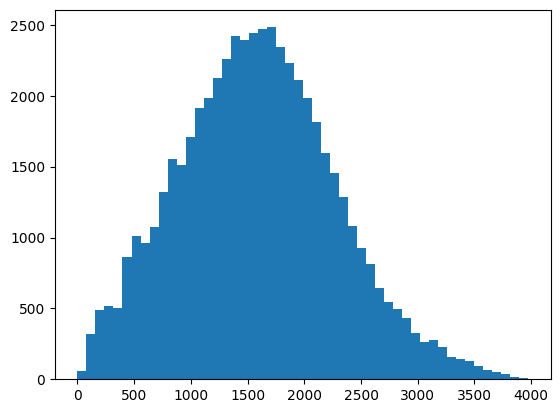

In [33]:
plt.hist(all_routes_no_inf[(all_routes_no_inf['departure_value'] > 0) & (all_routes_no_inf['destination_value'] > 0)]['length_km'], bins=50)
plt.show()

In [34]:
all_routes['path']

0        [(37.548438, -88.736011), (39.0, -80.0), (50.3...
1        [(37.548438, -88.736011), (39.0, -80.0), (49.3...
2        [(37.548438, -88.736011), (39.0, -90.0), (40.0...
3        [(37.548438, -88.736011), (39.0, -80.0), (49.4...
4        [(37.548438, -88.736011), (39.0, -80.0), (50.3...
                               ...                        
55849                   [83489efffffffff, 8344dbfffffffff]
55850                   [83489efffffffff, 8344ddfffffffff]
55851                   [83489efffffffff, 8344defffffffff]
55852                   [83489efffffffff, 8344e9fffffffff]
55853                   [83489efffffffff, 8344ebfffffffff]
Name: path, Length: 55854, dtype: object

In [35]:
#all_routes = pd.read_pickle(f'{species}/resolution_{resolution}/tables/{species}_all_routes_fw_{elevation_limit}.pkl')

In [36]:
path_length = all_routes_no_inf.apply(lambda row: len(row.path), axis=1)
path_length

0        3
1        3
2        6
3        3
4        3
        ..
55849    2
55850    2
55851    2
55852    2
55853    2
Length: 53940, dtype: int64

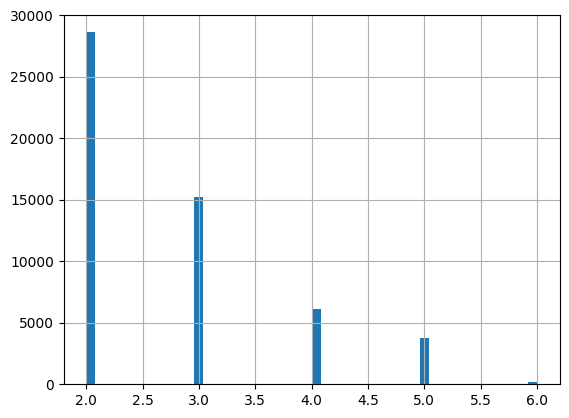

In [37]:
path_length.hist(bins=50)
plt.show()

In [38]:
all_routes_path_length = all_routes_no_inf[path_length == 6]

In [39]:
all_routes_path_length

,departure_cell,departure_value,destination_cell,destination_value,length_km,intersection,path
2,832641fffffffff,0.000062,830e4afffffffff,0.000021,2233.649106,True,"[(37.548438, -88.736011), (39.0, -90.0), (40.0..."
5,832641fffffffff,0.000062,830e59fffffffff,0.000026,2126.184268,True,"[(37.548438, -88.736011), (39.0, -90.0), (40.0..."
6,832641fffffffff,0.000062,830e5bfffffffff,0.000409,2022.883165,True,"[(37.548438, -88.736011), (39.0, -90.0), (40.0..."
118,832641fffffffff,0.000062,83274dfffffffff,0.002732,949.928693,True,"[(37.548438, -88.736011), (39.0, -90.0), (40.0..."
141,832641fffffffff,0.000062,832768fffffffff,0.000894,1139.614578,True,"[(37.548438, -88.736011), (39.0, -90.0), (40.0..."
...,...,...,...,...,...,...,...
47649,8344e9fffffffff,0.008077,832768fffffffff,0.000894,1558.776460,True,"[(33.898672, -87.350476), (39.0, -90.0), (40.0..."
47652,8344e9fffffffff,0.008077,83276bfffffffff,0.001632,1447.707358,True,"[(33.898672, -87.350476), (39.0, -90.0), (40.0..."
48910,8344edfffffffff,0.008023,83274dfffffffff,0.002732,1472.832500,True,"[(32.833373, -87.616932), (39.0, -90.0), (40.0..."
48933,8344edfffffffff,0.008023,832768fffffffff,0.000894,1662.518385,True,"[(32.833373, -87.616932), (39.0, -90.0), (40.0..."


In [40]:
print(all_routes_path_length.iloc[10])

departure_cell                                         832641fffffffff
departure_value                                               0.000062
destination_cell                                       832ab4fffffffff
destination_value                                             0.001255
length_km                                                  1197.531019
intersection                                                      True
path                 [(37.548438, -88.736011), (39.0, -90.0), (40.0...
Name: 213, dtype: object


In [41]:
# origin = '832641fffffffff'
# target = '832664fffffffff'
# origin = '832641fffffffff'
# target = '832b9afffffffff'
origin = '832641fffffffff'
target = '832ab4fffffffff'

In [42]:
row = all_routes.loc[
    (all_routes['departure_cell'] == origin) &
    (all_routes['destination_cell'] == target)]

In [43]:
row.length_km

213    1197.531019
Name: length_km, dtype: float64

In [44]:
path = row.path.squeeze()

In [45]:
print(origin, target)
print(barriers[0])

832641fffffffff 832ab4fffffffff
POLYGON ((-81 40, -85 43, -80 40, -80 39, -90 39, -90 40, -81 40))


In [46]:
#path = routes.loc[routes['path'].str.len().idxmax(), 'path']

In [47]:
path

[(37.548438, -88.736011),
 (39.0, -90.0),
 (40.0, -90.0),
 (41.0, -87.0),
 (43.0, -85.0),
 (43.24081, -80.862712)]

In [48]:
# Create GeoDataFrame for barriers
cells_gdf = h3_cells_to_gdf([origin, target])

# Plot base layer
ax = df.plot(
    facecolor="wheat",
    linewidth=0.2,
    edgecolor="tan",
    figsize=(30, 10),
    legend=True
)

# Overlay barriers in red
def edge_color(row):
    if row["cell"] == origin:
        return "green"
    elif row["cell"] == target:
        return "red"
    else:
        return 'blue'

cells_gdf["facecolor"] = cells_gdf.apply(edge_color, axis=1)

cells_gdf.plot(ax=ax, facecolor=cells_gdf['facecolor'], alpha=0.5, linewidth=0.5)

for poly in barriers:
    x, y = poly.exterior.xy
    plt.plot(x, y, color='red')

# Split into x and y lists
x = [p[1] for p in path]  # longitudes
y = [p[0] for p in path]  # latitudes
plt.plot(x, y, color='blue')

# Save the combined plot
plt.savefig(f"{species}/resolution_{resolution}/plots/path_{pathfinding_method}.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [ ]:
path_gdf = h3_cells_to_gdf(path)
path_gdf

In [ ]:
# Create GeoDataFrame for barriers
#barrier_gdf = h3_cells_to_gdf(barriers)
path_gdf = h3_cells_to_gdf(path)

# Plot base layer
ax = df.plot(
    facecolor="wheat",
    linewidth=0.2,
    edgecolor="tan",
    figsize=(30, 10),
    legend=True
)

# Overlay barriers in red
#barrier_gdf.plot(ax=ax, facecolor="red", edgecolor="red", alpha=0.5, linewidth=0.5)
def edge_color(row):
    if row["cell"] == origin:
        return "green"
    elif row["cell"] == target:
        return "red"
    else:
        return 'blue'

path_gdf["facecolor"] = path_gdf.apply(edge_color, axis=1)

path_gdf.plot(ax=ax, facecolor=path_gdf['facecolor'], alpha=0.5, linewidth=0.5)

for poly in barriers:
    x, y = poly.exterior.xy
    plt.plot(x, y)


# Save the combined plot
plt.savefig(f"{species}/resolution_{resolution}/plots/path.pdf", dpi=300, bbox_inches="tight")
plt.close()

checking strange stopovers

In [275]:
import h3

total_path_distance = 0

path1 = ['832aa3fffffffff',
 '832aa4fffffffff',
 '832b85fffffffff',
 '832ba3fffffffff',
 '830e4afffffffff']

print(f"{'Step':<10} | {'From -> To':<20} | {'Distance (km)':<15}")
print("-" * 50)

# 1. Calculate Segment-by-Segment Distance
for i in range(len(path1) - 1):
    # Get coordinates (lat, lng)
    # Note: ensure you use the correct h3 version function (cell_to_latlng for v4, h3_to_geo for v3)
    p1 = h3.cell_to_latlng(path1[i])
    p2 = h3.cell_to_latlng(path1[i+1])
    
    # Calculate distance
    dist = h3.great_circle_distance(p1, p2, unit='km')
    total_path_distance += dist
    
    print(f"{i} -> {i+1:<5} | {path1[i]} -> {path1[i+1]:<8} | {dist:.4f}")

print("-" * 50)

# 2. Calculate Direct Distance (Start to End)
start_coords = h3.cell_to_latlng(path1[0])
end_coords = h3.cell_to_latlng(path1[-1])
direct_distance = h3.great_circle_distance(start_coords, end_coords, unit='km')

print(f"SUM of segments:  {total_path_distance:.4f} km")
print(f"DIRECT distance:  {direct_distance:.4f} km")
print(f"Difference:       {total_path_distance - direct_distance:.4f} km")

Step       | From -> To           | Distance (km)  
--------------------------------------------------
0 -> 1     | 832aa3fffffffff -> 832aa4fffffffff | 237.8244
1 -> 2     | 832aa4fffffffff -> 832b85fffffffff | 490.6414
2 -> 3     | 832b85fffffffff -> 832ba3fffffffff | 125.3562
3 -> 4     | 832ba3fffffffff -> 830e4afffffffff | 381.1817
--------------------------------------------------
SUM of segments:  1235.0037 km
DIRECT distance:  1235.0037 km
Difference:       0.0000 km


# Model

In [287]:
cfg = {
    'model': 'ln',                # варианты 'min', 'ln', 'ln_var', 'naive'
    #'alpha': 0.01,                 # только для 'min' и 'ln'
    'algorithm': 'favorite chain' # только для 'min' и 'ln'; 
                                  # варианты: 'leapfrog', 'chain', 'fcfs', 
                                  # 'favorite leapfrog', 'favorite mix', 'favorite chain'
}

In [288]:
# TODO change to match case?

def build_routes(algorithm, df, all_routes, breeding_favorite_threshold):
    if algorithm == 'fcfs':
        routes = all_routes.merge(
            df[['cell', 'value_breeding']],
            left_on='destination_cell',
            right_on='cell',
            how='left'
        )

        routes = routes.sort_values(
            by=['value_breeding', 'length_km'],
            ascending=[False, True]
        )

    elif algorithm == 'favorite leapfrog':
        routes = all_routes.merge(
            df[['cell', 'value_breeding']],
            left_on='destination_cell',
            right_on='cell',
            how='left'
        )

        favorites = routes[routes['value_breeding'] > breeding_favorite_threshold].sort_values(by='length_km', ascending=True)
        the_rest = routes[routes['value_breeding'] <= breeding_favorite_threshold].sort_values(by='length_km', ascending=True)

        routes = pd.concat([favorites, the_rest], ignore_index=True)

    elif algorithm == 'favorite mix':
        # TODO check this
        routes = all_routes.merge(
            df[['cell', 'value_breeding']],
            left_on='destination_cell',
            right_on='cell',
            how='left'
        ).drop(columns=['cell'])

        merged = routes.merge(
            df[['cell', 'lat']],
            left_on='departure_cell',
            right_on='cell',
            how='left'
        ).drop(columns=['cell'])

        favorites = merged[merged['value_breeding'] > breeding_favorite_threshold].sort_values(by='length_km', ascending=True)
        the_rest = merged[merged['value_breeding'] <= breeding_favorite_threshold]

        max_distance = the_rest['length_km'].max()
        max_lat = the_rest['lat'].max()
        min_lat = the_rest['lat'].min()

        penalty = max_distance * (1 - (max_lat - the_rest['lat']) / (max_lat - min_lat))
        
        the_rest['length_km'] += penalty
        the_rest = the_rest.sort_values(by='length_km', ascending=True)
        
        routes = pd.concat([favorites, the_rest], ignore_index=True)


    elif algorithm == 'favorite chain':
        # TODO check this
        routes = all_routes.merge(
            df[['cell', 'value_breeding']],
            left_on='destination_cell',
            right_on='cell',
            how='left'
        ).drop(columns=['cell'])

        merged = routes.merge(
            df[['cell', 'lat']],
            left_on='departure_cell',
            right_on='cell',
            how='left'
        ).drop(columns=['cell'])

        favorites = merged[merged['value_breeding'] > breeding_favorite_threshold].sort_values(by='length_km', ascending=True)
        the_rest = merged[merged['value_breeding'] <= breeding_favorite_threshold]

        max_distance = favorites['length_km'].max()
        max_lat = favorites['lat'].max()
        min_lat = favorites['lat'].min()

        penalty = max_distance * (1 - (max_lat - favorites['lat']) / (max_lat - min_lat))
        favorites['length_km'] += penalty
        favorites = favorites.sort_values(by='length_km', ascending=True)

        max_distance = the_rest['length_km'].max()
        max_lat = the_rest['lat'].max()
        min_lat = the_rest['lat'].min()

        penalty = max_distance * (1 - (max_lat - the_rest['lat']) / (max_lat - min_lat))
        the_rest['length_km'] += penalty
        the_rest = the_rest.sort_values(by='length_km', ascending=True)
        
        routes = pd.concat([favorites, the_rest], ignore_index=True)


    else: 
        routes = all_routes.copy()
        if algorithm == 'chain':
            # Merge once
            merged = all_routes.merge(
                df[['cell', 'lat']],
                left_on='departure_cell',
                right_on='cell',
                how='left'
            ).drop(columns=['cell'])

            max_distance = merged['length_km'].max()
            max_lat = merged['lat'].max()
            min_lat = merged['lat'].min()

            penalty = max_distance * (1 - (max_lat - merged['lat']) / (max_lat - min_lat))

            merged['length_km'] += penalty
            routes = merged.sort_values(by='length_km')

        elif algorithm == 'leapfrog':
            routes = routes.sort_values(by='length_km')
        
        else:
            raise ValueError("no such algorithm")
    
    return routes

In [289]:
def calculate_flow_naive(all_routes):
    routes = all_routes.copy()
    routes['flow'] = routes['departure_value'] * routes['destination_value']
    return routes

In [290]:
def calculate_flow_min(df, routes, alpha):
    dict = df.set_index('cell').to_dict(orient='index')
    
    flows = []
    for row in routes.itertuples(index=True):
        f = min(alpha * dict[row.departure_cell]['value_wintering'],
                dict[row.destination_cell]['value_breeding'])
        flows.append(f)

        dict[row.departure_cell]['value_wintering'] -= f
        dict[row.destination_cell]['value_breeding'] -= f

    return flows

In [291]:
def calculate_flow_ln(df, routes, alpha):
    df_copy = df.copy()
    df_copy['arrived'] = 0
    dict = df_copy.set_index('cell').to_dict(orient='index')
    
    flows = []
    for row in routes.itertuples(index=True):
        dep = dict[row.departure_cell]
        dest = dict[row.destination_cell]
        vb = dest['value_breeding']
        ar = dest['arrived']
        vw = dep['value_wintering']

        if (vb == 0):
            f = 0
        else:
            f = (np.log(1 + (ar + alpha * vw) / vb) * vb
                - np.log(1 + ar / vb) * vb)
        flows.append(f)

        dest['arrived'] += alpha * dep['value_wintering']
        dep['value_wintering'] -= f

    return flows

In [292]:
def optimize_ln(df, routes):
    def loss(df, routes, alpha):
        breeding = df.set_index('cell')['value_breeding'].copy()
        flows = np.array(calculate_flow_ln(df, routes, alpha))

        flow_df = routes.copy()
        flow_df['flow'] = flows
        flow_sum = flow_df.groupby('destination_cell')['flow'].sum()
        breeding.update(breeding.subtract(flow_sum, fill_value=0))

        return breeding.abs().sum()

    result = minimize_scalar(
        lambda alpha: loss(df, routes, alpha),
        bounds=(1e-6, 1.0),
        method='bounded'
    )

    return result.x, result.fun

In [293]:
def calculate_flow_ln_var(df, routes, alpha):
    df_copy = df.copy()
    df_copy['arrived'] = 0
    dict = df_copy.set_index('cell').to_dict(orient='index')
    max_lat = routes['lat'].max()
    min_lat = routes['lat'].min()

    def landing_prob(lat):
        return alpha[0] + (1 - alpha[0]) / (1 + np.exp(alpha[2] * (- (lat - min_lat) / (max_lat - min_lat) + alpha[1])))
    
    flows = []
    for row in routes.itertuples(index=True):
        dep = dict[row.departure_cell]
        dest = dict[row.destination_cell]
        vb = dest['value_breeding']
        ar = dest['arrived']
        vw = dep['value_wintering']

        if (vb == 0):
            f = 0
        else:
            f = (np.log(1 + (ar + landing_prob(row.lat) * vw) / vb) * vb
                - np.log(1 + ar / vb) * vb)
        flows.append(f)

        dest['arrived'] += landing_prob(row.lat) * dep['value_wintering']
        dep['value_wintering'] -= f

    return flows

In [294]:
def optimize_ln_var(df, routes):
    def loss(df, routes, alpha):
        breeding = df.set_index('cell')['value_breeding'].copy()
        flows = np.array(calculate_flow_ln_var(df, routes, alpha))

        flow_df = routes.copy()
        flow_df['flow'] = flows
        flow_sum = flow_df.groupby('destination_cell')['flow'].sum()
        breeding.update(breeding.subtract(flow_sum, fill_value=0))

        return breeding.abs().sum()

    alpha0 = [1, 1e-6, 1]
    result = minimize(
        lambda alpha: loss(df, routes, alpha),
        alpha0,
        bounds=[(1e-6, 1.0),(1e-6, 1.0),(1, 100)],
        method='L-BFGS-B'
    )

    return result.x, result.fun

In [295]:
def model(cfg, df, all_routes, breeding_favorite_threshold):
    if cfg['model'] == 'naive':
        return calculate_flow_naive(df, all_routes)

    routes = build_routes(cfg['algorithm'], df, all_routes, breeding_favorite_threshold)

    if cfg['model'] == 'min':
        routes['flow'] = calculate_flow_min(df, routes, cfg['alpha'])
        return routes

    if cfg['model'] == 'ln':
        alpha_opt, loss_opt = optimize_ln(df, routes)
        print(f"Optimal alpha: {alpha_opt:.6f}, loss: {loss_opt:.4f}")
        routes['flow'] = np.array(calculate_flow_ln(df, routes, alpha_opt))
        return routes
    
    if cfg['model'] == 'ln_var':
        alpha_opt, loss_opt = optimize_ln_var(df, routes)
        print(f"Optimal alpha: {alpha_opt}, loss: {loss_opt:.4f}")
        routes['flow'] = np.array(calculate_flow_ln_var(df, routes, alpha_opt))
        return routes

    raise ValueError(f"Unknown model {cfg['model']}")

In [296]:
routes = model(cfg, df, all_routes, breeding_favorite_threshold)

/tmp/ipykernel_1690473/3078492882.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  the_rest['length_km'] += penalty
/tmp/ipykernel_1690473/729196080.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.33078336e-03 -4.17479884e-03  2.12043997e-05 -2.28691019e-03
 -3.17461447e-03  2.58726232e-05  4.09391767e-04  1.54482927e-06
  3.45451117e-05 -1.33856586e-03 -8.77319907e-04  9.28456575e-06
  1.37811348e-05  1.05486531e-03  4.54040583e-06  8.98401959e-06
  2.83241534e-05  6.83842009e-05  2.15603068e-04  1.37662866e-07
  5.64447114e-08  3.35906952e-06  6.52193080e-07  7.07029467e-05
  1.24562039e-05  6.00867543e-06  5.81282191e-04  9.14127682e-04
  2.24504649e

Optimal alpha: 0.024713, loss: 0.2704


In [95]:
#routes = model(cfg, df, all_routes, breeding_favorite_threshold)

[3.49670107e-03 9.73051614e-01 9.99999756e+01], loss: 0.2988

## Experiments with alpha and amewoo

In [18]:
routes = build_routes(cfg['algorithm'], df, all_routes, breeding_favorite_threshold)

/tmp/ipykernel_855249/822142936.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  the_rest['length_km'] += penalty


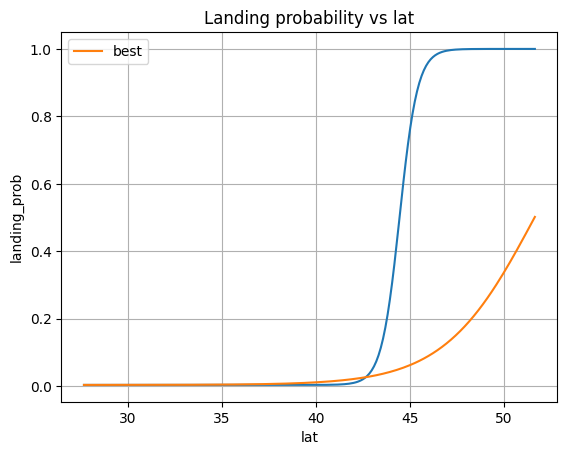

In [94]:
alpha_best = [0.0035, 1, 10]
alpha = [0.0035, 0.7, 50]

max_lat = routes['lat'].max()
min_lat = routes['lat'].min()

def landing_prob(alpha, lat):
    return alpha[0] + (1 - alpha[0]) / (1 + np.exp(alpha[2] * (- (lat - min_lat) / (max_lat - min_lat) + alpha[1])))

x = np.linspace(min_lat, max_lat, 200)
y_best = [landing_prob(alpha_best, xi) for xi in x]
y = [landing_prob(alpha, xi) for xi in x]

plt.plot(x, y)
plt.plot(x, y_best, label='best')
plt.xlabel("lat")
plt.ylabel("landing_prob")
plt.title("Landing probability vs lat")
plt.legend()
plt.grid(True)
plt.show()


In [92]:
def optimize_beta(df, routes, alpha):
    def loss(df, routes, alpha, beta):
        breeding = df.set_index('cell')['value_breeding'].copy()
        alpha[1] = beta
        flows = np.array(calculate_flow_ln_var(df, routes, alpha))

        flow_df = routes.copy()
        flow_df['flow'] = flows
        flow_sum = flow_df.groupby('destination_cell')['flow'].sum()
        breeding.update(breeding.subtract(flow_sum, fill_value=0))

        return breeding.abs().sum()

    result = minimize_scalar(
        lambda beta: loss(df, routes, alpha, beta),
        bounds=(1e-6, 1.0),
        method='bounded'
    )

    return result.x, result.fun

In [93]:
print(optimize_beta(df, routes, [0.0035, 1, 50]))

(np.float64(0.7075625327866557), np.float64(0.3020241824109391))


In [83]:
# alpha = [0.0035, 1, 10]

alpha = [0.0035, 0.4, 50]
routes['flow'] = np.array(calculate_flow_ln_var(df, routes, alpha))

In [84]:
def loss(df, routes):
        breeding = df.set_index('cell')['value_breeding'].copy()

        flow_sum = routes.groupby('destination_cell')['flow'].sum()
        breeding.update(breeding.subtract(flow_sum, fill_value=0))

        return breeding.abs().sum()

In [85]:
print(loss(df, routes))

0.6202800261338579


In [299]:
routes_nonzero = routes[routes["flow"] != 0]

In [300]:
print(routes_nonzero.flow.sum())

0.9397454608075959


In [301]:
routes_nonzero.head()

,departure_cell,departure_value,destination_cell,destination_value,length_km,intersection,path,value_breeding,lat,flow
0,8344a8fffffffff,2.026840e-05,832aa3fffffffff,0.004299,1497.108828,False,"[8344a8fffffffff, 832aa3fffffffff]",0.004299,27.694317,5.008603e-07
1,8344adfffffffff,3.016710e-08,832aa3fffffffff,0.004299,1505.638738,False,"[8344adfffffffff, 832aa3fffffffff]",0.004299,27.425037,7.454274e-10
2,8344abfffffffff,2.440305e-06,832aa3fffffffff,0.004299,1527.241886,False,"[8344abfffffffff, 832aa3fffffffff]",0.004299,28.722186,6.029937e-08
3,8344a9fffffffff,1.278394e-03,832aa3fffffffff,0.004299,1535.664882,False,"[8344a9fffffffff, 832aa3fffffffff]",0.004299,28.463701,3.147310e-05
4,83441afffffffff,8.236758e-04,832aa3fffffffff,0.004299,1549.820901,False,"[83441afffffffff, 832aa3fffffffff]",0.004299,28.192684,2.015689e-05


In [302]:
routes_nonzero.shape

(55854, 10)

## save routes 

In [303]:
def save_routes(routes, species, cfg):
    
    model_name = cfg['model']
    algorithm = cfg.get('algorithm')
    alpha = cfg.get('alpha')
    
    base_dir = f"{species}/resolution_{resolution}/tables/{model_name}"
    if algorithm is not None:
        base_dir = os.path.join(base_dir, algorithm)
    
    os.makedirs(base_dir, exist_ok=True)
    
    file_name = f"{model_name}"
    if algorithm is not None:
        file_name += f" {algorithm}"
    if alpha is not None:
        file_name += f" {alpha}"
    file_name += ".csv"

    routes.to_csv(os.path.join(base_dir, file_name), index=False)


In [304]:
save_routes(routes_nonzero, species, cfg)

# Plots

In [ ]:
# routes_nonzero = pd.read_csv(f"{species}/tables/{model}/{model}_{alpha}.csv")
routes_nonzero = pd.read_csv(f'/home/gkim/birds/{species}/resolution_{resolution}/tables/ln/favorite chain/ln favorite chain.csv')

In [305]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, IntSlider, Output, interactive, Play, VBox, jslink
from IPython.display import HTML

In [306]:
# %matplotlib widget

In [307]:
df_plot = df.copy()
df_plot["abundance"] = df_plot["value_wintering"].copy()
df_plot.drop(columns=["value_breeding", "value_wintering", "diff", "lat", "lng"], inplace=True)

In [320]:
batch_size = 1000

In [321]:
# cache = [df_plot.copy()]

# for start in range(0, len(routes_nonzero), batch_size):
#     end = min(start + batch_size, len(routes_nonzero))

#     # Apply flows up to the current step
#     flows = routes_nonzero[start:end].groupby("departure_cell")["flow"].sum()
#     df_plot.loc[df_plot["cell"].isin(flows.index), "abundance"] -= df_plot["cell"].map(flows).astype("float32")

#     flows = routes_nonzero[start:end].groupby("destination_cell")["flow"].sum()
#     df_plot.loc[df_plot["cell"].isin(flows.index), "abundance"] += df_plot["cell"].map(flows).astype("float32")

#     cache.append(df_plot.copy())

In [322]:
cache = [df_plot.copy()]

cells = df_plot.set_index("cell")  # fast lookup by cell

for start in range(0, len(routes_nonzero), batch_size):
    end = min(start + batch_size, len(routes_nonzero))
    batch = routes_nonzero.iloc[start:end]

    # Net flow per cell in this batch: -departures + arrivals
    net_flows = (
        batch.groupby("departure_cell")["flow"].sum().rename("outflow").mul(-1)
        .add(batch.groupby("destination_cell")["flow"].sum(), fill_value=0)
    )

    # Update abundances in place
    cells.loc[net_flows.index, "abundance"] += net_flows.astype("float32")

    cache.append(cells.reset_index().copy())

In [323]:
len(cache)

57

In [324]:
cache[-1].head()

,cell,geometry,abundance
0,830e48fffffffff,"POLYGON ((-68.66052 51.03693, -69.60227 50.726...",0.001634
1,830e49fffffffff,"POLYGON ((-67.84616 50.02359, -68.76993 49.720...",0.008153
2,830e4afffffffff,"POLYGON ((-70.50471 51.06901, -71.43508 50.743...",0.000107
3,830e4bfffffffff,"POLYGON ((-69.64258 50.06704, -70.55639 49.749...",0.008495
4,830e4dfffffffff,"POLYGON ((-66.82606 50.97612, -67.77717 50.680...",0.006087


In [325]:
# plot difference map
df_res = cache[-1].copy()
df_res["abundance"] = df["value_breeding"] - df_res["abundance"]

# Determine the symmetric range around zero
max_abs = np.nanmax(np.abs(df_res["abundance"]))
vmin, vmax = -max_abs, max_abs

ax = df_res.plot(
    column="abundance",
    linewidth=0,
    edgecolor=None,
    legend=True,
    cmap="coolwarm",  # diverging for positive/negative differences
    figsize=(30, 10),
    vmin=vmin,
    vmax=vmax  # ensures zero is in the center
)
plt.title("true_value_breeding - abundance")


# name
plt.savefig(f"{species}/resolution_{resolution}/plots/res_custom_alpha.pdf", dpi=300, bbox_inches="tight")
plt.close()


## Prerendered animation

In [326]:
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 50 * 1024**2  # 50 MB

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=150)
vmax = np.nanmax(df[["value_breeding", "value_wintering"]])
norm=plt.Normalize(vmin=0, vmax=vmax)
plt.tight_layout()
sm = plt.cm.ScalarMappable(cmap="magma_r", norm=norm)
fig.colorbar(sm, ax=ax)

# Initial plot
plot = cache[0].plot(
    column="abundance",
    cmap="magma_r",
    linewidth=0.2,
    edgecolor="black",
    ax=ax,
    legend=False,
    norm=norm
)

# --- Animation update function ---
def update(step):
    df_step = cache[step]
    new_values = df_step["abundance"].values
    new_norm = plt.Normalize(vmin=0, vmax=new_values.max())
    
    sm.set_norm(new_norm)
    c = ax._children[0]
    c.set_array(new_values)
    c.set_norm(new_norm)

    ax.set_title(f"Abundance after {step} steps")

    return [c]

# Reduce frames if needed for memory
frame_indices = range(0, len(cache), 1)  # use step>1 if cache is huge

ani = FuncAnimation(
    fig,
    update,
    frames=frame_indices,
    interval=100,
    blit=False,  # blit=True can cause issues in Jupyter, False is safe
    repeat=False
)

# Display animation
display(HTML(ani.to_jshtml()))
plt.close(fig)

In [328]:
ani.save(f"{species}/resolution_{resolution}/plots/ln_{model}.gif", writer="pillow", fps=10)
#ani.save(f"{species}/plots/{model}_{alpha}.gif", writer="pillow", fps=10)